### Pycrash impact simulation using impulse-momentum with vehicle motion

In [1]:
# %% allow reloading of modules
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.getcwd()

'/Users/joe/Documents/pycrash/projects/validation impact momentum/notebooks'

In [3]:
import sys
sys.path.insert(0,'/Users/joe/Documents/pycrash')

In [4]:
from pycrash.project import Project, project_info, load_project
from pycrash.vehicle import Vehicle
from pycrash.kinematics import SingleMotion
from pycrash.kinematicstwo import KinematicsTwo
from pycrash.model_calcs.carpenter_momentum import IMPC
from pycrash.model_calcs.position_data import position_data_static
from pycrash.visualization.initial_positions import initial_position
from pycrash.visualization.kinematics_compare import compare_kinematics
from pycrash.visualization.model_interval_two_vehicles import plot_motion_interval
from pycrash.visualization.model_interval import plot_motion_interval as single_interval
from pycrash.visualization.cg_motion_compare import cg_motion
from src.vehicle_data_collection import vehicle_data
from src.test_inputs_rose import test_data

Current values for defined constants:
maximum available friction (mu_max) = 0.76
time step for vehicle motion (dt) = 0.01 s
No Environment File Provided
No Environment File Provided


In [6]:
import pandas as pd
import numpy as np
from scipy import integrate
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import math

In [7]:
# PC Crash vehicle specifications
vehicle_input_dict = {"year":2004,  # <- creates dictionary of vehicle data for input
"make":"Chevrolet",
"model":"Malibu",
"weight":3298,
"vin":"1G1ZU54854F135916",
"brake":0,
"steer_ratio":15.9,
"init_x_pos":0,
"init_y_pos":0,
"head_angle":0,
"width":70 / 12,
"length":187 / 12,
"hcg":21.5 / 12,
"lcgf":38.1 / 12,
"lcgr":67.9 / 12,
"wb":106 / 12,
"track":60 / 12,
"f_hang":38 / 12,
"r_hang":43 / 12,
"tire_d":26.2 / 12,
"tire_w":8.5 / 12,
"izz":2040,
"fwd":1,
"rwd":0,
"awd":0,
"A":100,
"B":41,
"k":1000,
"L":0,
"c":0,
"vx_initial":0,
"vy_initial":0,
"omega_z":0}

In [8]:
veh1 = Vehicle('Striking', vehicle_input_dict)
veh2 = Vehicle('Struck', vehicle_input_dict)

Vehicle inputs for Striking applied succesfully
Vehicle inputs for Struck applied succesfully


In [9]:
t = [0, 5]
brake = [0, 0]
throttle = [0, 0]
steer = [0, 0]
veh1.time_inputs(t, throttle, brake, steer)
veh1.vx_initial = 30
veh1.hcg = 1   

Driver inputs applied to Striking


In [10]:
veh2.time_inputs(t, throttle, brake, steer)
veh2.vx_initial = 0
veh2.hcg = 1  

Driver inputs applied to Struck


In [11]:
# define impact point - Vehicle 1
# left front corner
veh1.pimpact_x = veh1.lcgf + veh1.f_hang - 1
veh1.pimpact_y = (- veh1.width / 2) + 1
veh1.impact_norm_rad = -16.5 * np.pi / 180
veh1.striking = True

In [12]:
# define impact edge - Vehicle 2
#option 4
veh2.edgeimpact = 4
veh2.edgeimpact_x1 = -1 * veh2.lcgr - veh2.r_hang
veh2.edgeimpact_y1 = -1 * veh2.width / 2
veh2.edgeimpact_x2 = veh2.lcgf + veh2.f_hang
veh2.edgeimpact_y2 = -1 * veh2.width / 2
veh2.striking = False

### Initial Positions

In [31]:
# Vehicle 1
veh1.init_x_pos = 0
veh1.init_y_pos = 0
veh1.head_angle = 0

# Vehicle 2
veh2.init_x_pos = 40
veh2.init_y_pos = -10
veh2.head_angle = -90

In [32]:
initial_position(position_data_static([veh1, veh2]))

In [16]:
#### needs to show inputs cof, cor, etc.

In [33]:
run = KinematicsTwo('run1', 'IMPC', veh1, veh2, user_sim_defaults={'dt_motion': 0.01,
                                                                   'mu_max': 0.76,
                                                                   'alpha_max': 0.174533,  # 10 degrees
                                                                   'vehicle_mu': 0.6,
                                                                   'cor': 0.1})

Driver input for Striking of shape = (501, 4)
Driver input for Struck of shape = (501, 4)
Predefined impact point for Striking: x=5.3, y=-1.9, impact plane angle: -16.5
Predefined impact edge for Struck x1=-9.2, y1=-2.9166666666666665; x2=6.3, y2=-2.9


In [34]:
run.simulate()

Impact Type: IMPC
Two vehicle simulation will run for 5.0 s
Model Fx: 0.0 at i: 0
Model Fx: 0.0 at i: 0
Impact Detect: False at i: 0
Model Fx: 0.0 at i: 1
Model Fx: 0.0 at i: 1
Impact Detect: False at i: 1
Model Fx: 0.0 at i: 2
Model Fx: 0.0 at i: 2
Impact Detect: False at i: 2
Model Fx: 0.0 at i: 3
Model Fx: 0.0 at i: 3
Impact Detect: False at i: 3
Model Fx: 0.0 at i: 4
Model Fx: 0.0 at i: 4
Impact Detect: False at i: 4


/Users/joe/Documents/pycrash/pycrash/model_calcs/impact_detect.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/joe/Documents/pycrash/pycrash/model_calcs/impact_detect.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/joe/Documents/pycrash/pycrash/model_calcs/impact_detect.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/joe/Documents/pycrash/pycrash/model_calcs/impact_detect.py:70: SettingWithCopyWarnin

Model Fx: 0.0 at i: 5
Model Fx: 0.0 at i: 5
Impact Detect: False at i: 5
Model Fx: 0.0 at i: 6
Model Fx: 0.0 at i: 6
Impact Detect: False at i: 6
Model Fx: 0.0 at i: 7
Model Fx: 0.0 at i: 7
Impact Detect: False at i: 7
Model Fx: 0.0 at i: 8
Model Fx: 0.0 at i: 8
Impact Detect: False at i: 8
Model Fx: 0.0 at i: 9
Model Fx: 0.0 at i: 9
Impact Detect: False at i: 9
Model Fx: 0.0 at i: 10
Model Fx: 0.0 at i: 10
Impact Detect: False at i: 10
Model Fx: 0.0 at i: 11
Model Fx: 0.0 at i: 11
Impact Detect: False at i: 11
Model Fx: 0.0 at i: 12
Model Fx: 0.0 at i: 12
Impact Detect: False at i: 12
Model Fx: 0.0 at i: 13
Model Fx: 0.0 at i: 13
Impact Detect: False at i: 13
Model Fx: 0.0 at i: 14
Model Fx: 0.0 at i: 14
Impact Detect: False at i: 14
Model Fx: 0.0 at i: 15
Model Fx: 0.0 at i: 15
Impact Detect: False at i: 15
Model Fx: 0.0 at i: 16
Model Fx: 0.0 at i: 16
Impact Detect: False at i: 16
Model Fx: 0.0 at i: 17
Model Fx: 0.0 at i: 17
Impact Detect: False at i: 17
Model Fx: 0.0 at i: 18
Mode

/Users/joe/Documents/pycrash/pycrash/model_calcs/impact_detect.py:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model Fx: 0.0 at i: 75
Impact Detect: nan at i: 75
Model Fx: 0.0 at i: 76
Model Fx: 0.0 at i: 76
Impact Detect: nan at i: 76
Model Fx: 0.0 at i: 77
Model Fx: 0.0 at i: 77
Impact Detect: nan at i: 77
Model Fx: 0.0 at i: 78
Model Fx: 0.0 at i: 78
Impact Detect: nan at i: 78
Model Fx: 0.0 at i: 79
Model Fx: 0.0 at i: 79
Impact Detect: nan at i: 79
Model Fx: 0.0 at i: 80
Model Fx: 0.0 at i: 80
Impact Detect: nan at i: 80
Model Fx: 0.0 at i: 81
Model Fx: 0.0 at i: 81
Impact Detect: nan at i: 81
Model Fx: 0.0 at i: 82
Model Fx: 0.0 at i: 82
Impact Detect: nan at i: 82
Model Fx: 0.0 at i: 83
Model Fx: 0.0 at i: 83
Impact Detect: nan at i: 83
Model Fx: 0.0 at i: 84
Model Fx: 0.0 at i: 84
Impact Detect: nan at i: 84
Model Fx: 0.0 at i: 85
Model Fx: 0.0 at i: 85
Impact Detect: nan at i: 85
Model Fx: 0.0 at i: 86
Model Fx: 0.0 at i: 86
Impact Detect: nan at i: 86
Model Fx: 0.0 at i: 87
Model Fx: 0.0 at i: 87
Impact Detect: nan at i: 87
Model Fx: 0.0 at i: 88
Model Fx: 0.0 at i: 88
Impact Detect: 

Model Fx: 0.0 at i: 185
Impact Detect: nan at i: 185
Model Fx: 0.0 at i: 186
Model Fx: 0.0 at i: 186
Impact Detect: nan at i: 186
Model Fx: 0.0 at i: 187
Model Fx: 0.0 at i: 187
Impact Detect: nan at i: 187
Model Fx: 0.0 at i: 188
Model Fx: 0.0 at i: 188
Impact Detect: nan at i: 188
Model Fx: 0.0 at i: 189
Model Fx: 0.0 at i: 189
Impact Detect: nan at i: 189
Model Fx: 0.0 at i: 190
Model Fx: 0.0 at i: 190
Impact Detect: nan at i: 190
Model Fx: 0.0 at i: 191
Model Fx: 0.0 at i: 191
Impact Detect: nan at i: 191
Model Fx: 0.0 at i: 192
Model Fx: 0.0 at i: 192
Impact Detect: nan at i: 192
Model Fx: 0.0 at i: 193
Model Fx: 0.0 at i: 193
Impact Detect: nan at i: 193
Model Fx: 0.0 at i: 194
Model Fx: 0.0 at i: 194
Impact Detect: nan at i: 194
Model Fx: 0.0 at i: 195
Model Fx: 0.0 at i: 195
Impact Detect: nan at i: 195
Model Fx: 0.0 at i: 196
Model Fx: 0.0 at i: 196
Impact Detect: nan at i: 196
Model Fx: 0.0 at i: 197
Model Fx: 0.0 at i: 197
Impact Detect: nan at i: 197
Model Fx: 0.0 at i: 198

Impact Detect: nan at i: 292
Model Fx: 0.0 at i: 293
Model Fx: 0.0 at i: 293
Impact Detect: nan at i: 293
Model Fx: 0.0 at i: 294
Model Fx: 0.0 at i: 294
Impact Detect: nan at i: 294
Model Fx: 0.0 at i: 295
Model Fx: 0.0 at i: 295
Impact Detect: nan at i: 295
Model Fx: 0.0 at i: 296
Model Fx: 0.0 at i: 296
Impact Detect: nan at i: 296
Model Fx: 0.0 at i: 297
Model Fx: 0.0 at i: 297
Impact Detect: nan at i: 297
Model Fx: 0.0 at i: 298
Model Fx: 0.0 at i: 298
Impact Detect: nan at i: 298
Model Fx: 0.0 at i: 299
Model Fx: 0.0 at i: 299
Impact Detect: nan at i: 299
Model Fx: 0.0 at i: 300
Model Fx: 0.0 at i: 300
Impact Detect: nan at i: 300
Model Fx: 0.0 at i: 301
Model Fx: 0.0 at i: 301
Impact Detect: nan at i: 301
Model Fx: 0.0 at i: 302
Model Fx: 0.0 at i: 302
Impact Detect: nan at i: 302
Model Fx: 0.0 at i: 303
Model Fx: 0.0 at i: 303
Impact Detect: nan at i: 303
Model Fx: 0.0 at i: 304
Model Fx: 0.0 at i: 304
Impact Detect: nan at i: 304
Model Fx: 0.0 at i: 305
Model Fx: 0.0 at i: 305

Model Fx: 0.0 at i: 401
Model Fx: 0.0 at i: 401
Impact Detect: nan at i: 401
Model Fx: 0.0 at i: 402
Model Fx: 0.0 at i: 402
Impact Detect: nan at i: 402
Model Fx: 0.0 at i: 403
Model Fx: 0.0 at i: 403
Impact Detect: nan at i: 403
Model Fx: 0.0 at i: 404
Model Fx: 0.0 at i: 404
Impact Detect: nan at i: 404
Model Fx: 0.0 at i: 405
Model Fx: 0.0 at i: 405
Impact Detect: nan at i: 405
Model Fx: 0.0 at i: 406
Model Fx: 0.0 at i: 406
Impact Detect: nan at i: 406
Model Fx: 0.0 at i: 407
Model Fx: 0.0 at i: 407
Impact Detect: nan at i: 407
Model Fx: 0.0 at i: 408
Model Fx: 0.0 at i: 408
Impact Detect: nan at i: 408
Model Fx: 0.0 at i: 409
Model Fx: 0.0 at i: 409
Impact Detect: nan at i: 409
Model Fx: 0.0 at i: 410
Model Fx: 0.0 at i: 410
Impact Detect: nan at i: 410
Model Fx: 0.0 at i: 411
Model Fx: 0.0 at i: 411
Impact Detect: nan at i: 411
Model Fx: 0.0 at i: 412
Model Fx: 0.0 at i: 412
Impact Detect: nan at i: 412
Model Fx: 0.0 at i: 413
Model Fx: 0.0 at i: 413
Impact Detect: nan at i: 413

In [35]:
run.draw_simulation(10)
#run.draw_simulation(64)

### Load PC-Crash Data

In [17]:
pc_crash_column_names = ['t', 'ax', 'ay', 'az', 'phi_deg', 'lf_fy', 'rf_fy',
                         'lr_fy', 'rr_fy', 'delta_deg', 'rf_delta_deg', 'steer',
                         'steer_rate', 'X', 'Y', 'Z', 'roll', 'pitch', 'theta_deg',
                         'Vx', 'Vy', 'Vz', 'rf_fz', 'lf_fz', 'rr_fz', 'lr_fz',
                         'rf_alpha', 'lf_alpha', 'lr_alpha', 'rr_alpha']

In [18]:
test_file_list = os.listdir(os.path.join(os.getcwd(), 'data', 'input'))
print('List of tests for analysis:')
test_file_list

List of tests for analysis:


['brachTestData.pkl',
 '__pycache__',
 'README.md',
 '30-mph-inline-impact-data.xlsx',
 '~$30-mph-t-impact-data.xlsx',
 '30-mph-t-impact-data.xlsx']

In [19]:
test_do = 5 # <- cho|ose test number from list to process
print(f'Test to be processed: {test_file_list[test_do]}')

Test to be processed: 30-mph-t-impact-data.xlsx


In [20]:
df = pd.read_excel(os.path.join(os.getcwd(), 'data', 'input', test_file_list[test_do]),
                            na_filter = False, header = None, names = pc_crash_column_names, skiprows = 2,
                            usecols = 'A:AD', nrows=51, sheet_name='target data')

In [27]:
df = pd.read_excel(os.path.join(os.getcwd(), 'data', 'input', test_file_list[test_do]),
                            na_filter = False, header = None, names = pc_crash_column_names, skiprows = 2,
                            usecols = 'A:AD', nrows=51, sheet_name='bullet data')

In [21]:
df.head()

,t,ax,ay,az,phi_deg,lf_fy,rf_fy,lr_fy,rr_fy,delta_deg,rf_delta_deg,steer,steer_rate,X,Y,Z,roll,pitch,theta_deg,Vx,Vy,Vz,rf_fz,lf_fz,rr_fz,lr_fz,rf_alpha,lf_alpha,lr_alpha,rr_alpha
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,90.0,0.0,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0
1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,90.0,0.0,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0
2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,90.0,0.0,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0
3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,90.0,0.0,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0
4,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,90.0,0.0,0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0


In [22]:
#df.steer = [x * -1 for x in df.steer]  # reverse steer - PC-Crash is positive ccw

# convert velocities to fps
df.Vx = [x * 1.46667 for x in df.Vx]
df.Vy = [x * -1.46667 for x in df.Vy]
df.Vz = [x * 1.46667 for x in df.Vz]

# convert acceleration to fps/s
df.ax = [x * 32.2 for x in df.ax]
df.ay = [x * -32.2 for x in df.ay]
df.az = [x * 32.2 for x in df.az]

# convert tire forces to lb
df.lf_fy = [x * 1000 for x in df.lf_fy]
df.rf_fy = [x * 1000 for x in df.rf_fy]
df.lr_fy = [x * 1000 for x in df.lr_fy]
df.rr_fy = [x * 1000 for x in df.rr_fy]

# steer angle in radians
df['delta_rad'] = [x / 180 * np.pi for x in df.delta_deg]

# integrate velocities to get displacements
df['Dx'] = df.X
df['Dy'] = [x * -1 for x in df.Y]

df['theta_deg'] = [x * -1 for x in df.theta_deg]
df.head()

,t,ax,ay,az,phi_deg,lf_fy,rf_fy,lr_fy,rr_fy,delta_deg,rf_delta_deg,steer,steer_rate,X,Y,Z,roll,pitch,theta_deg,Vx,Vy,Vz,rf_fz,lf_fz,rr_fz,lr_fz,rf_alpha,lf_alpha,lr_alpha,rr_alpha,delta_rad,Dx,Dy
0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,-90.0,0.0,-0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,40.0,-10.0
1,0.1,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,-90.0,0.0,-0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,40.0,-10.0
2,0.2,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,-90.0,0.0,-0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,40.0,-10.0
3,0.3,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,-90.0,0.0,-0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,40.0,-10.0
4,0.4,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40.0,10.0,1.79,0.0,0.0,-90.0,0.0,-0.0,0.0,1.055634,1.055634,0.592337,0.592337,0.0,0.0,0.0,0.0,0.0,40.0,-10.0


In [23]:
target = df.copy()

In [30]:
bullet = df.copy()

In [31]:
run.__dict__.keys()

dict_keys(['name', 'type', 'veh1', 'veh2', 'impact_type', 'sim_defaults', 'crush_data'])

In [36]:
# calculate vehicle slip angle for pycrash model - need to correct
phi_rad = []
phi_deg = []
for i in range(len(run.veh1.model.t)):
    phi_rad.append(math.atan2(run.veh1.model.vy[i], run.veh1.model.vx[i])) 
    phi_deg.append(math.atan2(run.veh1.model.vy[i], run.veh1.model.vx[i])*(180 / math.pi))    
    
run.veh1.model['phi_rad'] = phi_rad
run.veh1.model['phi_deg'] = phi_deg

In [37]:
# calculate vehicle slip angle for pycrash model - need to correct
phi_rad = []
phi_deg = []
for i in range(len(run.veh2.model.t)):
    phi_rad.append(math.atan2(run.veh2.model.vy[i], run.veh2.model.vx[i])) 
    phi_deg.append(math.atan2(run.veh2.model.vy[i], run.veh2.model.vx[i])*(180 / math.pi))    
    
run.veh2.model['phi_rad'] = phi_rad
run.veh2.model['phi_deg'] = phi_deg

In [38]:
compare_kinematics(run.veh2.model, target, 'Pycrash', 'PC-Crash')

In [39]:
cg_motion(run.veh2.model, target, 'Pycrash', 'PC-Crash')

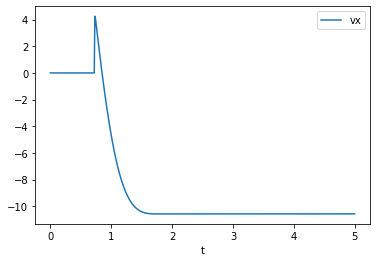

In [41]:
import matplotlib.pyplot as plt
run.veh2.model.plot(x='t', y='vx')
plt.show()